In [1]:
!pip install xgboost
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 1.7 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=c7c4a5958a4d5bc3718a09b24266d4e42f6bd3f9a1e4dcc2f10fd09cab984ea7
  Stored in directory: /home/ec2-user/.cache/pip/wheels/37/fa/19/f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import gc
import time
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from IPython.display import clear_output
from xgboost import XGBClassifier, DMatrix
from bayes_opt import BayesianOptimization
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold

pd.set_option('display.max_columns', None)

Matplotlib is building the font cache; this may take a moment.


In [3]:
train_file = './train.gz'
test_file = './test.gz'
samplesubmision_file = './sampleSubmission.gz'

# EDA

In [4]:
chunksize = 10 ** 6
train_sample_frac = .05

total_train_count = 0
num_of_chunk = 0

train_df = pd.DataFrame()

drop_columns = ['id']
types_map = {}

In [5]:
top_100 = pd.read_csv(train_file, compression='gzip', nrows=100)
top_100.drop('id', inplace=True, axis=1)
top_100.head(3)

click      hour    C1  banner_pos   site_id site_domain site_category  \
0      0  14102100  1005           0  1fbe01fe    f3845767      28905ebd   
1      0  14102100  1005           0  1fbe01fe    f3845767      28905ebd   
2      0  14102100  1005           0  1fbe01fe    f3845767      28905ebd   

     app_id app_domain app_category device_id device_ip device_model  \
0  ecad2386   7801e8d9     07d7df22  a99f214a  ddd2926e     44956a24   
1  ecad2386   7801e8d9     07d7df22  a99f214a  96809ac8     711ee120   
2  ecad2386   7801e8d9     07d7df22  a99f214a  b3cf8def     8a4875bd   

   device_type  device_conn_type    C14  C15  C16   C17  C18  C19     C20  C21  
0            1                 2  15706  320   50  1722    0   35      -1   79  
1            1                 0  15704  320   50  1722    0   35  100084   79  
2            1                 0  15704  320   50  1722    0   35  100084   79

In [6]:
top_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   click             100 non-null    int64 
 1   hour              100 non-null    int64 
 2   C1                100 non-null    int64 
 3   banner_pos        100 non-null    int64 
 4   site_id           100 non-null    object
 5   site_domain       100 non-null    object
 6   site_category     100 non-null    object
 7   app_id            100 non-null    object
 8   app_domain        100 non-null    object
 9   app_category      100 non-null    object
 10  device_id         100 non-null    object
 11  device_ip         100 non-null    object
 12  device_model      100 non-null    object
 13  device_type       100 non-null    int64 
 14  device_conn_type  100 non-null    int64 
 15  C14               100 non-null    int64 
 16  C15               100 non-null    int64 
 17  C16              

In [7]:
del top_100

## 取 5% 資料出來探索

In [8]:
types_map = {
    'id': np.dtype(str),
    'click': np.uint8,
    'hour': np.dtype(int),
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str)
}

In [9]:
num_of_chunk = 0
for chunk in pd.read_csv(train_file, compression='gzip', dtype=types_map, chunksize=chunksize):
    num_of_chunk += 1
    total_train_count += len(chunk)
    if num_of_chunk == 1:
        train_df = chunk.sample(frac=train_sample_frac, replace=False, random_state=2022)
    else:
        train_df = pd.concat([train_df, chunk.sample(frac=train_sample_frac, replace=False, random_state=123)], axis=0)
    print(f'Processing Chunk No.{ num_of_chunk }')

del chunk
clear_output()

print(f'num_of_chunk: {num_of_chunk}')
print(f'total_train_count: {total_train_count}')
print(f'train_df count: {len(train_df)}')

num_of_chunk: 41
total_train_count: 40428967
train_df count: 2021448


### 合併 train & test data

In [10]:
concat_df = pd.concat([train_df, pd.read_csv(test_file, compression='gzip', dtype=types_map)]).drop(['id'], axis=1)

### 時間處理

In [11]:
concat_df['weekday'] = pd.to_datetime(concat_df['hour'].astype(np.dtype(str)).apply(lambda x: f'20{x[:2]}-{x[2:4]}-{x[4:6]}')).dt.dayofweek.astype(str)

In [12]:
concat_df['hour'] = concat_df['hour'].apply(lambda x: x%100).astype(str)

### 各欄位的唯一值數量

In [13]:
for column in concat_df.columns:
    print(f'{column}: {len(concat_df[column].unique())}')

click: 3
hour: 24
C1: 7
banner_pos: 7
site_id: 3492
site_domain: 4328
site_category: 24
app_id: 5482
app_domain: 319
app_category: 31
device_id: 552801
device_ip: 1875291
device_model: 6320
device_type: 5
device_conn_type: 4
C14: 2660
C15: 8
C16: 9
C17: 470
C18: 4
C19: 68
C20: 169
C21: 62
weekday: 7


### 大量特徵處理

In [16]:
ctr_step = 0.1
large_features_columns = ['site_id', 'site_domain',
                          'app_id', 'app_domain',
                          'device_id', 'device_ip', 'device_model',
                          'C14', 'C17', 'C19', 'C20', 'C21']

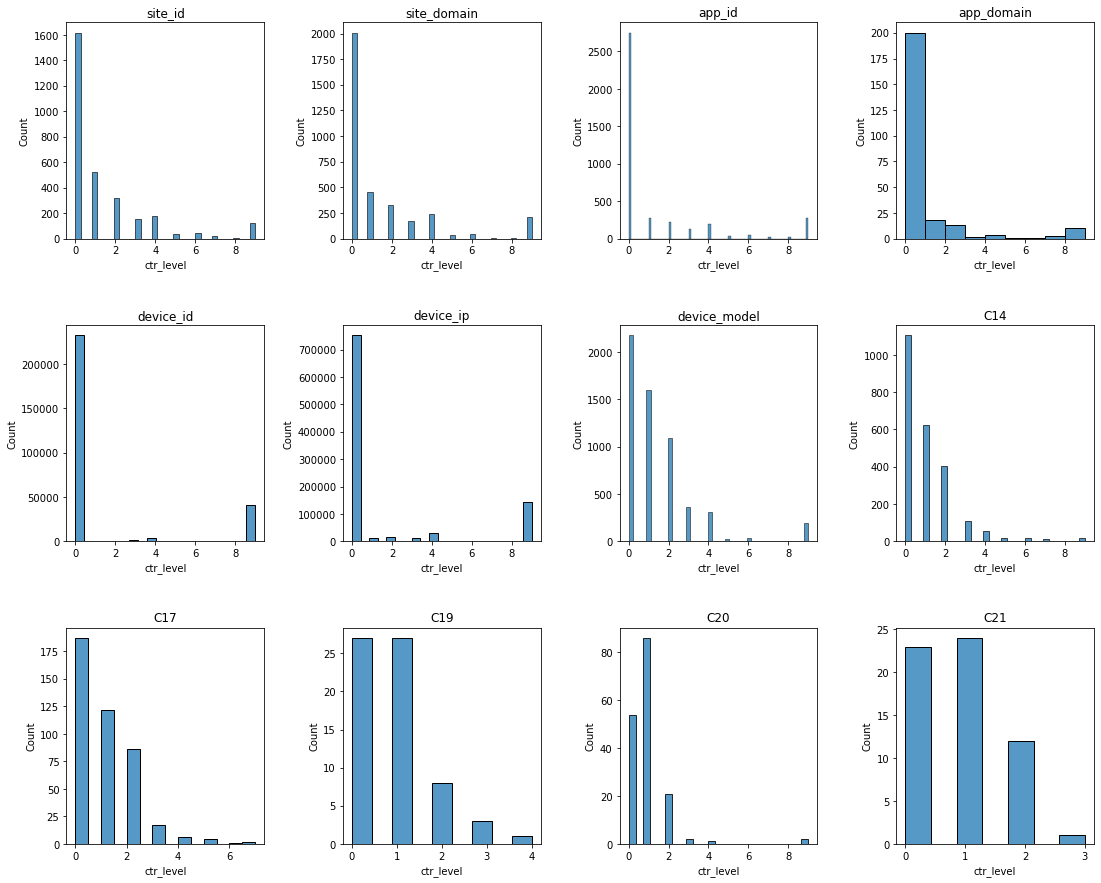

In [17]:
large_features_columns_mapping_dfs = {}

fig, ax = plt.subplots(3, 4, figsize=(15,12))
fig.tight_layout()

for i, column in enumerate(large_features_columns):
    print(column)
    df_0 = train_df[train_df['click'] == 0][column].value_counts()
    df_1 = train_df[train_df['click'] == 1][column].value_counts()
    df = pd.merge(left=df_0, right=df_1, how='outer', left_index=True, right_index=True, suffixes=('_0', '_1'))
    df.fillna(1e-6, inplace=True)
    df['ctr'] = df[f'{column}_1'] / (df[f'{column}_1'] + df[f'{column}_0'])
    df['ctr_level'] = (df['ctr'] // ctr_step).astype('uint8')
    
    large_features_columns_mapping_dfs[f'{column}'] = df['ctr_level'].copy()
    train_df[f'{column}_level'] = train_df[f'{column}'].apply(lambda x: large_features_columns_mapping_dfs[f'{column}'][str(x)])
    
    ax[i//4, i%4].set_title(f'{column}')
    sns.histplot(df, x='ctr_level', ax=ax[i//4, i%4])

del df_0, df_1, df
clear_output()
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(15,12))
fig.tight_layout()

for i, column in enumerate(large_features_columns):
    sns.countplot(data=train_df, x=f'{column}_level', hue='click', ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'{column}')
    ax[i//4, i%4].set_xticks(list(range(0,20)))
    ax[i//4, i%4].set_xticklabels(list(range(0,20)))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

### 大量特徵資料轉換

In [19]:
for i, column in enumerate(large_features_columns):
    concat_df[f'{column}_level'] = concat_df[f'{column}'].apply(lambda x: large_features_columns_mapping_dfs[column][x] if x in large_features_columns_mapping_dfs[column] else 0).astype(np.dtype(str))

In [20]:
concat_df.drop(large_features_columns, inplace=True, axis=1)

In [25]:
concat_df = pd.get_dummies(concat_df)

In [31]:
concat_df.to_csv('concat_df.csv', index=False)
concat_df[concat_df['click'].notna()].to_csv('train.csv', index=False)
concat_df[concat_df['click'].isna()].drop('click', axis=1).to_csv('test.csv', index=False)

In [37]:
del concat_df

# Training model

In [4]:
train_df = pd.read_csv('train.csv', dtype=np.dtype('uint8'))
test_df = pd.read_csv('test.csv', dtype=np.dtype('uint8'))

In [7]:
balanced_train_df = train_df[train_df['click'] == 0].sample(n=len(train_df[train_df['click'] == 1]), random_state=2022)
balanced_train_df = pd.concat([balanced_train_df, train_df[train_df['click'] == 1]]).sample(frac=1)

In [9]:
train_df, valid_df = train_test_split(balanced_train_df, test_size=0.20, random_state=2022)

In [12]:
print(f'train: {len(train_df)}, valid: {len(valid_df)}')

train: 549820, valid: 137456


In [17]:
y_train = train_df['click']
X_train = train_df.drop('click', axis=1)
y_valid = valid_df['click']
X_valid = valid_df.drop('click', axis=1)

## Train model

In [22]:
def xgbc_cv(min_child_weight, max_depth, gamma, learning_rate, n_estimators, reg_alpha, reg_lambda):
    estimator = XGBClassifier(tree_method='gpu_hist',
                              min_child_weight=int(min_child_weight),
                              max_depth=int(max_depth),
                              gamma=gamma,
                              learning_rate=learning_rate,
                              n_estimators=int(n_estimators),
                              reg_alpha=reg_alpha,
                              reg_lambda=reg_lambda,
                              nthread=-1,
                              objective='binary:logistic')
    # Fit the estimator
    estimator.fit(X_train, y_train)
    models.append(estimator)
    
    # calculate out-of-the-box roc_score using validation set 1
    predict = estimator.predict(X_valid)
    score = roc_auc_score(y_valid, predict)
    
    # return the mean validation score to be maximized 
    return score

In [23]:
models = []

hyperparameter_space = {
    'min_child_weight': (4,20),
    'max_depth': (15,20),
    'gamma': (0,1),
    'learning_rate': (0,1),
    'n_estimators' : (500,2000),
    'reg_alpha': (0,1),
    'reg_lambda': (0,1)
}

xgbcBO = BayesianOptimization(f=xgbc_cv,
                              pbounds=hyperparameter_space,
                              random_state=2022,
                              verbose=10)

gp_params = {"alpha": 1e-10}

xgbcBO.maximize(init_points=5, n_iter=10, acq='ucb', kappa=3, **gp_params)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.8612   |  0.009359 |  0.4991   |  15.57    |  4.8      |  1.528e+0 |  0.487    |  0.8977   |
|  2        |  0.8714   |  0.6475   |  0.897    |  18.61    |  17.3     |  1.741e+0 |  0.8336   |  0.957    |
|  3        |  0.8729   |  0.368    |  0.4948   |  16.7     |  13.91    |  1.966e+0 |  0.09643  |  0.7442   |
|  4        |  0.8722   |  0.2925   |  0.2987   |  18.76    |  4.299    |  1.286e+0 |  0.8644   |  0.3888   |
|  5        |  0.872    |  0.2122   |  0.4752   |  17.82    |  9.591    |  1.964e+0 |  0.03782  |  0.7943   |
|  6        |  0.8732   |  0.3614   |  0.1117   |  15.99    |  18.46    |  1.999e+0 |  0.2206   |  0.1046   |
|  7        |  0.8732   |  0.707    |  0.01437  |  19.54    |  16.8     |  1.209e+0 |  0.5383   |  0.8989   |
|  8      

In [24]:
xgbcBO.max

{'target': 0.8734418260892886,
 'params': {'gamma': 0.3091530880697494,
  'learning_rate': 0.07825267585118678,
  'max_depth': 17.085842309242995,
  'min_child_weight': 19.7410265928101,
  'n_estimators': 872.4632115004342,
  'reg_alpha': 0.6344562996448365,
  'reg_lambda': 0.46578306000308134}}

In [25]:
scores = []
for model in models:
    predictions = model.predict(X_valid)
    score = roc_auc_score(y_valid, predictions)
    scores.append(score)

In [26]:
best_model = models[np.argmax(scores)]
max(scores)

0.8734418260892886

In [27]:
predictions = best_model.predict(X_valid)
confmat = confusion_matrix(y_true=y_valid, y_pred=predictions, labels=[0, 1])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

## Save model

In [28]:
best_model.save_model('model.json')
best_model.save_model('model.txt')

# Sumbittion

In [5]:
best_model = XGBClassifier()
best_model.load_model('model.json')

In [6]:
sample_submission_df = pd.read_csv('sampleSubmission.gz', compression='gzip', nrows=100)
sample_submission_df.head(3)

id  click
0  10000174058809263569    0.5
1  10000182526920855428    0.5
2  10000554139829213984    0.5

In [7]:
submission_df = pd.read_csv('test.gz', compression='gzip', dtype={'id': np.dtype(str)})
submission_df = submission_df[['id']]

In [8]:
submission_df['click'] = best_model.predict_proba(test_df)[:,1]

In [9]:
submission_df

id     click
0        10000174058809263569  0.999849
1        10000182526920855428  0.403544
2        10000554139829213984  0.614655
3        10001094637809798845  0.007631
4        10001377041558670745  0.007089
...                       ...       ...
4577459   9998166651591969718  0.750784
4577460   9998249812366450951  0.013550
4577461     99988023653614546  0.744130
4577462   9999086574712596585  0.031939
4577463     99992636456518364  0.011333

[4577464 rows x 2 columns]

In [10]:
submission_df.to_csv('submission.csv', index=False)